Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-conv-var.ipynb)

In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Ewert&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Ewert; color:#ff6633;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Functions, & Classes')

In [3]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch
from torchvision.datasets import MNIST as tmnist
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
import tensorflow.image as timage
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [4]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [5]:
@register_line_magic
def display_examples(n):
    if n=='1': data_loader=train_loader
    if n=='2': data_loader=train_loader2
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size),
                      cmap=pl.cm.bone)
        break

In [6]:
dhtml('Data')

In [7]:
random_seed=12; batch_size=128; img_size=28
trans=transforms\
.Compose([transforms.Resize((img_size,img_size)),
          transforms.ToTensor()])
train=tmnist(root='data',train=True,
             download=True,transform=trans)
test=tmnist(root='data',train=False, 
            transform=trans)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Image dimensions: torch.Size([128, 1, 28, 28])
Label dimensions: torch.Size([128])




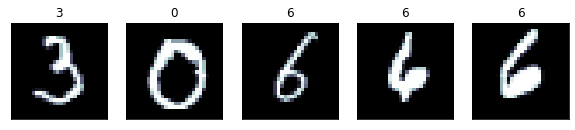

In [8]:
%display_examples 1

In [9]:
fpath='../input/classification-of-handwritten-letters/'
f='LetterColorImages_123.h5'
f=h5py.File(fpath+f,'r')
keys=list(f.keys()); print(keys)
x=1-np.array(f[keys[1]],dtype='float32')/255
x=timage.resize(x,[img_size,img_size])
x=(np.dot(x.numpy(),[.299,.587,.114]))\
.reshape(-1,1,img_size,img_size)
y=np.array(f[keys[2]],dtype='int32')-1
N=y.shape[0]; n=int(.2*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_train=x[:n],x[n:]
y_test,y_train=y[:n],y[n:]
random_seed=23; batch_size2=128
train2=TData(x_train,y_train)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,shuffle=True,
                  batch_size=batch_size2)
test_loader2=tdl(dataset=test2,shuffle=False,
                 batch_size=batch_size2)

['backgrounds', 'images', 'labels']


Image dimensions: torch.Size([128, 1, 28, 28])
Label dimensions: torch.Size([128])


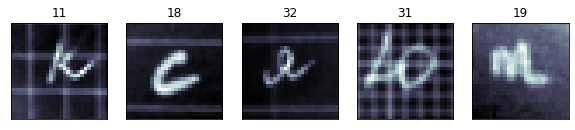

In [10]:
%display_examples 2

In [11]:
dhtml('Convolutional Variational <br/>Autoencoder')

In [12]:
class ConvVarAE(tnn.Module):
    def __init__(self,num_features,num_latent):
        super(ConvVarAE,self).__init__()
        # encoder
        self.conv_en1=tnn\
        .Conv2d(in_channels=1,out_channels=16,
                kernel_size=(6,6),stride=(2,2),
                padding=0)
        self.conv_en2=tnn\
        .Conv2d(in_channels=16,out_channels=32,
                kernel_size=(4,4),stride=(2,2),
                padding=0)                        
        self.conv_en3=tnn\
        .Conv2d(in_channels=32,out_channels=64,
                kernel_size=(2,2),stride=(2,2),
                padding=0)                           
        self.z_mean=tnn.Linear(64*2*2,num_latent)
        self.z_log_var=tnn.Linear(64*2*2,num_latent)
        # decoder
        self.linear_de1=tnn.Linear(num_latent,64*2*2)             
        self.deconv_de1=tnn\
        .ConvTranspose2d(in_channels=64,out_channels=32,
                         kernel_size=(2,2),stride=(2,2),
                         padding=0)                         
        self.deconv_de2=tnn\
        .ConvTranspose2d(in_channels=32,out_channels=16,
                         kernel_size=(4,4),stride=(3,3),
                         padding=1)       
        self.deconv_de3=tnn\
        .ConvTranspose2d(in_channels=16,out_channels=1,
                         kernel_size=(6,6),stride=(3,3),
                         padding=4)
    def reparameterize(self,z_mu,z_log_var):
        eps=torch.randn(z_mu.size(0),z_mu.size(1)).to(dev)
        return z_mu+eps*torch.exp(z_log_var/2.)       
    def encoder(self,features):
        x=self.conv_en1(features); x=tnnf.leaky_relu(x)       
        x=self.conv_en2(x); x=tnnf.leaky_relu(x)
        x=self.conv_en3(x); x=tnnf.leaky_relu(x)      
        z_mean=self.z_mean(x.view(-1,64*2*2))
        z_log_var=self.z_log_var(x.view(-1,64*2*2))
        encoded=self.reparameterize(z_mean,z_log_var)  
        return z_mean,z_log_var,encoded  
    def decoder(self,encoded):
        x=self.linear_de1(encoded)
        x=x.view(-1,64,2,2)     
        x=self.deconv_de1(x); x=tnnf.leaky_relu(x)       
        x=self.deconv_de2(x); x=tnnf.leaky_relu(x)      
        x=self.deconv_de3(x); x=tnnf.leaky_relu(x)
        decoded=torch.sigmoid(x)
        return decoded
    def forward(self,features):
        z_mean,z_log_var,encoded=self.encoder(features)
        decoded=self.decoder(encoded)
        return z_mean,z_log_var,encoded,decoded

In [13]:
dhtml('Training')

In [14]:
torch.manual_seed(random_seed)
learning_rate=.005; num_latent=15
model=ConvVarAE(num_features=img_size**2,
                num_latent=num_latent)
model=model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [15]:
epochs=30
for epoch in range(epochs):
    for batch_ids,(features,targets) in enumerate(train_loader):
        features=features.to(dev)
        z_mean,z_log_var,encoded,decoded=model(features)
        kl_divergence=(.5*(z_mean**2+torch.exp(z_log_var)-
                           z_log_var-1)).sum()
        pixelwise_bce=tnnf\
        .binary_cross_entropy(decoded,features,reduction='sum')
        cost=kl_divergence+pixelwise_bce
        optimizer.zero_grad()
        cost.backward(); optimizer.step()
        if not batch_ids%100:
            print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                   %(epoch+1,epochs,batch_ids, 
                     len(train_loader),cost))

Epoch: 001/030 | Batch: 000/469 | Cost: 69506.0156
Epoch: 001/030 | Batch: 100/469 | Cost: 27100.7715
Epoch: 001/030 | Batch: 200/469 | Cost: 24661.5410
Epoch: 001/030 | Batch: 300/469 | Cost: 22608.0918
Epoch: 001/030 | Batch: 400/469 | Cost: 21796.2207
Epoch: 002/030 | Batch: 000/469 | Cost: 21358.4883
Epoch: 002/030 | Batch: 100/469 | Cost: 20267.4238
Epoch: 002/030 | Batch: 200/469 | Cost: 20079.6074
Epoch: 002/030 | Batch: 300/469 | Cost: 19594.9668
Epoch: 002/030 | Batch: 400/469 | Cost: 19105.3672
Epoch: 003/030 | Batch: 000/469 | Cost: 18361.7266
Epoch: 003/030 | Batch: 100/469 | Cost: 18132.7324
Epoch: 003/030 | Batch: 200/469 | Cost: 17654.6211
Epoch: 003/030 | Batch: 300/469 | Cost: 17208.3730
Epoch: 003/030 | Batch: 400/469 | Cost: 16903.4219
Epoch: 004/030 | Batch: 000/469 | Cost: 17135.9570
Epoch: 004/030 | Batch: 100/469 | Cost: 17170.3867
Epoch: 004/030 | Batch: 200/469 | Cost: 16206.3164
Epoch: 004/030 | Batch: 300/469 | Cost: 16334.6504
Epoch: 004/030 | Batch: 400/469

In [16]:
dhtml('Reconstruction')

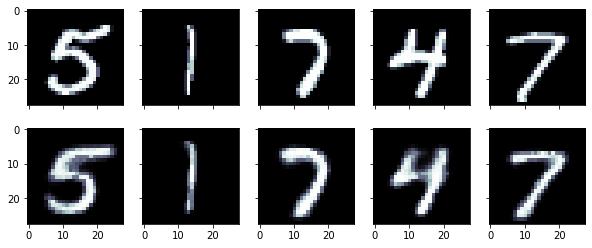

In [17]:
num_images=5
fig,axes=pl.subplots(nrows=2,ncols=num_images, 
                     sharex=True,sharey=True,
                     figsize=(10,4))
original_images=features[:num_images]
decoded_images=decoded[:num_images]
for i in range(num_images):
    for ax,img in zip(axes,[original_images,
                            decoded_images]):
        ax[i].imshow(img[i].detach().to(torch.device('cpu'))\
                     .reshape((img_size,img_size)),cmap='bone')

In [18]:
dhtml('Generating')

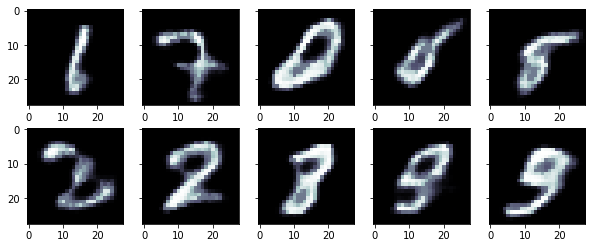

In [19]:
num_images=10
latent_features=\
torch.randn(num_images,num_latent).to(dev)
generated_images=model.decoder(latent_features)
decoded_images=generated_images[:num_images]
fig,axes=pl.subplots(nrows=2,ncols=num_images//2,
                     figsize=(10,4),sharey=True)
for ax,img in zip(axes.reshape(num_images),decoded_images):
    ax.imshow(img.detach().to(torch.device('cpu'))\
              .reshape((img_size,img_size)),cmap='bone')

In [20]:
dhtml('Convolutional Conditional <br/>Variational Autoencoder')

In [21]:
ch1,ch2,ch3=16,48,144
def to_onehot(labels,num_classes,device):
    labels_ohe=torch.zeros(labels.size()[0],
                           num_classes).to(device)
    labels_ohe.scatter_(1,labels.view(-1,1),1)
    return labels_ohe
class CondVarAE(tnn.Module):
    def __init__(self,num_features,num_latent,num_classes):
        super(CondVarAE,self).__init__()
        self.num_classes=num_classes
        # ENCODER
        self.conv_en1=tnn\
        .Conv2d(in_channels=1+self.num_classes,
                out_channels=ch1,kernel_size=(6,6),
                stride=(2,2),padding=0)
        self.conv_en2=tnn\
        .Conv2d(in_channels=ch1,out_channels=ch2,
                kernel_size=(4,4),stride=(2,2),
                padding=0)                        
        self.conv_en3=tnn\
        .Conv2d(in_channels=ch2,out_channels=ch3,
                kernel_size=(2,2),stride=(2,2),
                padding=0)                     
        self.z_mean=tnn.Linear(ch3*2*2,num_latent)
        self.z_log_var=tnn.Linear(ch3*2*2,num_latent)
        # DECODER
        self.linear_de1=tnn\
        .Linear(num_latent+self.num_classes,ch3*2*2)
        self.deconv_de1=tnn\
        .ConvTranspose2d(in_channels=ch3,out_channels=ch2,
                         kernel_size=(2,2),stride=(2,2),
                         padding=0)                              
        self.deconv_de2=tnn\
        .ConvTranspose2d(in_channels=ch2,out_channels=ch1,
                         kernel_size=(4,4),stride=(3,3),
                         padding=1)
        
        self.deconv_de3=tnn\
        .ConvTranspose2d(in_channels=ch1,out_channels=1,
                         kernel_size=(6,6),stride=(3,3),
                         padding=4)        
    def reparameterize(self, z_mu, z_log_var):
        eps=torch.randn(z_mu.size(0),z_mu.size(1)).to(dev)
        return z_mu+eps*torch.exp(z_log_var/2.)    
    def encoder(self,features,targets):
        onehot_targets=\
        to_onehot(targets,self.num_classes,dev)
        onehot_targets=\
        onehot_targets.view(-1,self.num_classes,1,1)        
        ones=torch.ones(features.size()[0], self.num_classes,
                        features.size()[2],features.size()[3], 
                        dtype=features.dtype).to(dev)
        ones=ones*onehot_targets
        x=torch.cat((features,ones),dim=1)        
        x=self.conv_en1(x); x=tnnf.leaky_relu(x)      
        x=self.conv_en2(x); x=tnnf.leaky_relu(x)
        x=self.conv_en3(x); x=tnnf.leaky_relu(x)     
        z_mean=self.z_mean(x.view(-1,ch3*2*2))
        z_log_var=self.z_log_var(x.view(-1,ch3*2*2))
        encoded=self.reparameterize(z_mean,z_log_var)
        return z_mean,z_log_var,encoded  
    def decoder(self,encoded,targets):
        onehot_targets=\
        to_onehot(targets,self.num_classes,dev)
        encoded=torch.cat((encoded,onehot_targets),dim=1)        
        x=self.linear_de1(encoded)
        x=x.view(-1,ch3,2,2)  
        x=self.deconv_de1(x); x=tnnf.leaky_relu(x)      
        x=self.deconv_de2(x); x=tnnf.leaky_relu(x)
        x=self.deconv_de3(x); x=tnnf.leaky_relu(x)
        decoded=torch.sigmoid(x)
        return decoded
    def forward(self,features,targets):      
        z_mean,z_log_var,encoded=self.encoder(features,targets)
        decoded=self.decoder(encoded,targets)     
        return z_mean,z_log_var,encoded,decoded

In [22]:
dhtml('Training 2')

In [23]:
torch.manual_seed(random_seed)
learning_rate=.0015; num_latent=121; num_classes=33
model=CondVarAE(num_features=img_size**2,
                num_latent=num_latent,
                num_classes=num_classes)
model=model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [24]:
epochs=200
for epoch in range(epochs):
    for batch_ids,(features,targets) in enumerate(train_loader2):
        features=features.to(dev)
        targets=targets.to(dev)
        z_mean,z_log_var,encoded,decoded=model(features,targets.long())
        kl_divergence=(.5*(z_mean**2+torch.exp(z_log_var)-
                           z_log_var-1)).sum()
        pixelwise_bce=tnnf\
        .binary_cross_entropy(decoded,features,reduction='sum')
        cost=kl_divergence+pixelwise_bce
        optimizer.zero_grad()
        cost.backward(); optimizer.step()
        if not batch_ids%50:
            print ('Epoch: %03d/%03d | Batch: %03d/%03d | Cost: %.4f' 
                   %(epoch+1,epochs,batch_ids, 
                     len(train_loader2),cost))

Epoch: 001/200 | Batch: 000/089 | Cost: 70784.0859
Epoch: 001/200 | Batch: 050/089 | Cost: 69402.9141
Epoch: 002/200 | Batch: 000/089 | Cost: 65449.6953
Epoch: 002/200 | Batch: 050/089 | Cost: 65639.2109
Epoch: 003/200 | Batch: 000/089 | Cost: 66259.8203
Epoch: 003/200 | Batch: 050/089 | Cost: 66133.5547
Epoch: 004/200 | Batch: 000/089 | Cost: 66136.6875
Epoch: 004/200 | Batch: 050/089 | Cost: 65442.6641
Epoch: 005/200 | Batch: 000/089 | Cost: 64987.1133
Epoch: 005/200 | Batch: 050/089 | Cost: 65188.4766
Epoch: 006/200 | Batch: 000/089 | Cost: 64605.6250
Epoch: 006/200 | Batch: 050/089 | Cost: 65826.8125
Epoch: 007/200 | Batch: 000/089 | Cost: 64856.4766
Epoch: 007/200 | Batch: 050/089 | Cost: 64741.5273
Epoch: 008/200 | Batch: 000/089 | Cost: 65559.3828
Epoch: 008/200 | Batch: 050/089 | Cost: 64932.1484
Epoch: 009/200 | Batch: 000/089 | Cost: 64037.4141
Epoch: 009/200 | Batch: 050/089 | Cost: 64567.3516
Epoch: 010/200 | Batch: 000/089 | Cost: 64503.9414
Epoch: 010/200 | Batch: 050/089

In [25]:
dhtml('Reconstruction 2')

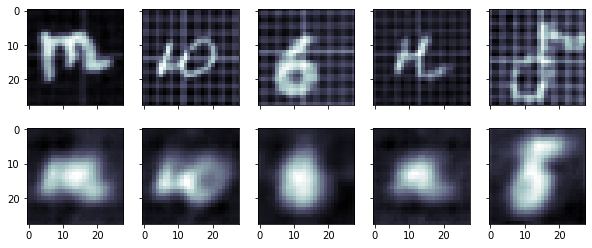

In [26]:
num_images=5
fig,axes=pl.subplots(nrows=2,ncols=num_images, 
                     sharex=True,sharey=True,
                     figsize=(10,4))
original_images=features[:num_images]
decoded_images=decoded[:num_images]
for i in range(num_images):
    for ax,img in zip(axes,[original_images,
                            decoded_images]):
        ax[i].imshow(img[i].detach().to(torch.device('cpu'))\
                     .reshape((img_size,img_size)),cmap='bone')

In [27]:
dhtml('Generating 2')

In [28]:
@register_line_magic
def display_gen(l):
    l=int(l); num_images=5
    labels=torch.tensor([l]*num_images).to(dev)
    latent_features=\
    torch.randn(num_images,num_latent).to(dev)
    generated_images=model.decoder(latent_features,labels)
    decoded_images=generated_images[:num_images]
    fig,axes=pl.subplots(nrows=1,ncols=num_images,
                         figsize=(10,2),sharey=True)
    for ax,img in zip(axes,decoded_images):
        ax.imshow(img.detach().to(torch.device('cpu'))\
                  .reshape((img_size,img_size)),cmap='bone')

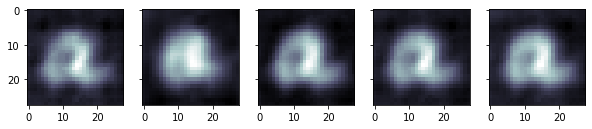

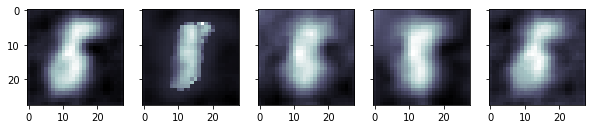

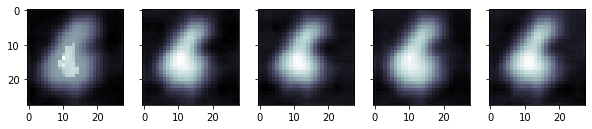

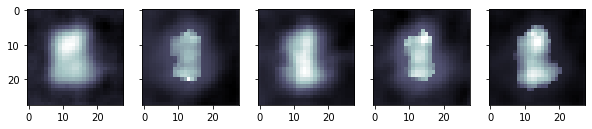

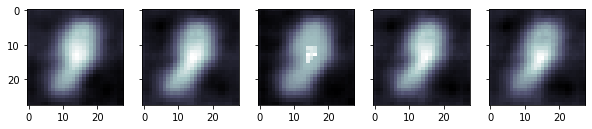

In [29]:
%display_gen 0
%display_gen 1
%display_gen 2
%display_gen 3
%display_gen 4